In [23]:
import collections
import math
import os
import random

import cv2
import numpy as np
import torch
from data_utils import affinity_utils
from torch.utils import data

import argparse
import json
import os
from datetime import datetime

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from model.models import MODELS
from road_dataset import DeepGlobeDataset, SpacenetDataset
from torch.autograd import Variable
from torch.optim.lr_scheduler import MultiStepLR
from utils.loss import CrossEntropyLoss2d, mIoULoss
from utils import util
from utils import viz_util
import matplotlib.pyplot as plt
import json

In [24]:
class RoadDataset(data.Dataset):
    def __init__(
        self, config, dataset_name, seed=7, multi_scale_pred=True, is_train=True
    ):
        # Seed
        np.random.seed(seed)
        torch.manual_seed(seed)
        random.seed(seed)

        self.split = "train" if is_train else "val"
        self.config = config
        # paths
        self.dir = self.config[dataset_name]["dir"]

        self.img_root = os.path.join(self.dir, "images/")
        self.gt_root = os.path.join(self.dir, "gt/")
        self.image_list = self.config[dataset_name]["file"]

        # list of all images
        self.images = [line.rstrip("\n") for line in open(self.image_list)]

        # augmentations
        self.augmentation = self.config["augmentation"]
        self.crop_size = [
            self.config[dataset_name]["crop_size"],
            self.config[dataset_name]["crop_size"],
        ]
        self.multi_scale_pred = multi_scale_pred

        # preprocess
        self.angle_theta = self.config["angle_theta"]
        self.mean_bgr = np.array(eval(self.config["mean"]))
        self.deviation_bgr = np.array(eval(self.config["std"]))
        self.normalize_type = self.config["normalize_type"]

        # to avoid Deadloack  between CV Threads and Pytorch Threads caused in resizing
        cv2.setNumThreads(0)

        self.files = collections.defaultdict(list)
        for f in self.images:
            self.files[self.split].append(
                {
                    "img": self.img_root
                    + f
                    + self.config[dataset_name]["image_suffix"],
                    "lbl": self.gt_root + f + self.config[dataset_name]["gt_suffix"],
                }
            )

    def __len__(self):
        return len(self.files[self.split])

    def getRoadData(self, index):

        image_dict = self.files[self.split][index]
        # read each image in list
        if os.path.isfile(image_dict["img"]):
            image = cv2.imread(image_dict["img"]).astype(np.float)
        else:
            print("ERROR: couldn't find image -> ", image_dict["img"])

        if os.path.isfile(image_dict["lbl"]):
            gt = cv2.imread(image_dict["lbl"], 0).astype(np.float)
        else:
            print("ERROR: couldn't find image -> ", image_dict["lbl"])

        if self.split == "train":
            image, gt = self.random_crop(image, gt, self.crop_size)
        else:
            image = cv2.resize(
                image,
                (self.crop_size[0], self.crop_size[1]),
                interpolation=cv2.INTER_LINEAR,
            )
            gt = cv2.resize(
                gt,
                (self.crop_size[0], self.crop_size[1]),
                interpolation=cv2.INTER_LINEAR,
            )

        if self.split == "train" and index == len(self.files[self.split]) - 1:
            np.random.shuffle(self.files[self.split])

        h, w, c = image.shape
        if self.augmentation == 1:
            flip = np.random.choice(2) * 2 - 1
            image = np.ascontiguousarray(image[:, ::flip, :])
            gt = np.ascontiguousarray(gt[:, ::flip])
            rotation = np.random.randint(4) * 90
            M = cv2.getRotationMatrix2D((w / 2, h / 2), rotation, 1)
            image = cv2.warpAffine(image, M, (w, h))
            gt = cv2.warpAffine(gt, M, (w, h))

        image = self.reshape(image)
        image = torch.from_numpy(np.array(image))

        return image, gt

    def getOrientationGT(self, keypoints, height, width):
        vecmap, vecmap_angles = affinity_utils.getVectorMapsAngles(
            (height, width), keypoints, theta=self.angle_theta, bin_size=10
        )
        vecmap_angles = torch.from_numpy(vecmap_angles)

        return vecmap_angles

    def reshape(self, image):

        if self.normalize_type == "Std":
            image = (image - self.mean_bgr) / (3 * self.deviation_bgr)
        elif self.normalize_type == "MinMax":
            image = (image - self.min_bgr) / (self.max_bgr - self.min_bgr)
            image = image * 2 - 1
        elif self.normalize_type == "Mean":
            image -= self.mean_bgr
        elif self.normalize_type == "Normalize":
            image = (image / 255.0)
        else:
            image = (image / 255.0) * 2 - 1
        
        image = image.transpose(2, 0, 1)
        return image

    def random_crop(self, image, gt, size):

        w, h, _ = image.shape
        crop_h, crop_w = size

        start_x = np.random.randint(0, w - crop_w)
        start_y = np.random.randint(0, h - crop_h)

        image = image[start_x : start_x + crop_w, start_y : start_y + crop_h, :]
        gt = gt[start_x : start_x + crop_w, start_y : start_y + crop_h]

        return image, gt

In [25]:
class StratfordDataset(RoadDataset):
    def __init__(self, config, seed=7, multi_scale_pred=True, is_train=True):
        super(StratfordDataset, self).__init__(
            config, "stratford", seed, multi_scale_pred, is_train
        )

        # preprocess
        self.threshold = self.config["thresh"]
        print("Threshold is set to {} for {}".format(self.threshold, self.split))

    def __getitem__(self, index):

        image, gt = self.getRoadData(index)
        c, h, w = image.shape

        labels = []
        vecmap_angles = []
        if self.multi_scale_pred:
            smoothness = [1, 2, 4]
            scale = [4, 2, 1]
        else:
            smoothness = [4]
            scale = [1]

        for i, val in enumerate(scale):
            if val != 1:
                gt_ = cv2.resize(
                    gt,
                    (int(math.ceil(h / (val * 1.0))), int(math.ceil(w / (val * 1.0)))),
                    interpolation=cv2.INTER_NEAREST,
                )
            else:
                gt_ = gt

            gt_orig = np.copy(gt_)
            gt_orig /= 255.0
            gt_orig[gt_orig < self.threshold] = 0
            gt_orig[gt_orig >= self.threshold] = 1
            labels.append(gt_orig)

            keypoints = affinity_utils.getKeypoints(
                gt_, thresh=0.98, smooth_dist=smoothness[i]
            )
            vecmap_angle = self.getOrientationGT(
                keypoints,
                height=int(math.ceil(h / (val * 1.0))),
                width=int(math.ceil(w / (val * 1.0))),
            )
            vecmap_angles.append(vecmap_angle)

        return image, labels, vecmap_angles

In [26]:
with open('test_config.json') as json_file:
    config = json.load(json_file)

In [27]:
config["train_dataset"]['normalize_type'] = 'Normalize'
config["train_dataset"]['stratford']['crop_size'] = 1024
config["train_dataset"]['spacenet']['crop_size'] = 600
config["train_dataset"]['deepglobe']['crop_size'] = 350

In [28]:
# train_dataset = SpacenetDataset(config["train_dataset"],
#                                 seed=config["seed"],
#                                 is_train=True,)

# train_loader = data.DataLoader(train_dataset, batch_size=1, shuffle = False)

In [29]:
train_dataset = StratfordDataset(config["train_dataset"],
                                seed=config["seed"],
                                is_train=True,)

train_loader = data.DataLoader(train_dataset, batch_size=30, shuffle = False)

Threshold is set to 0.76 for train


In [30]:
for i, sample in enumerate(train_loader):
    inputsBGR, labels, vecmap_angles = sample
    
    break

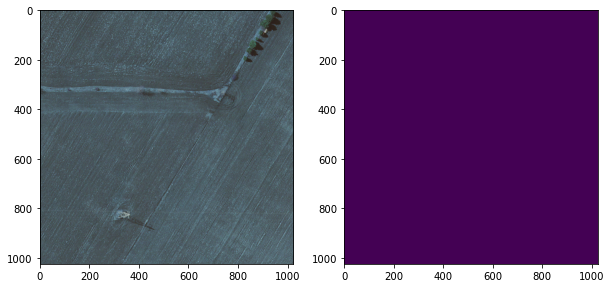

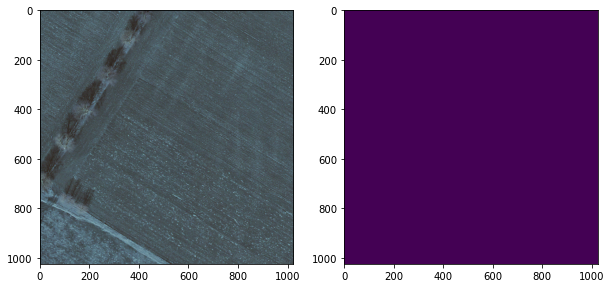

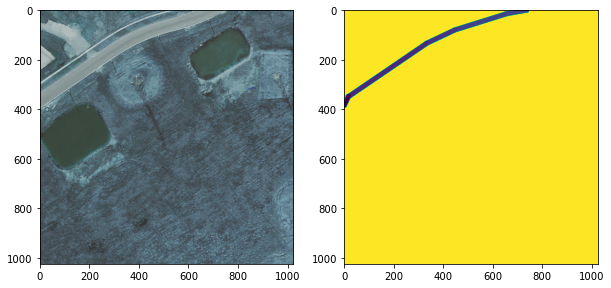

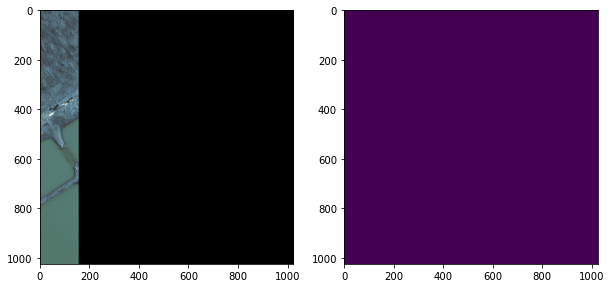

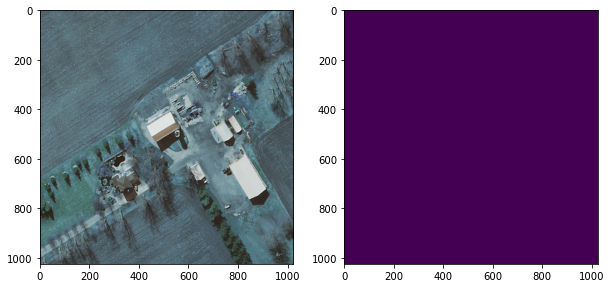

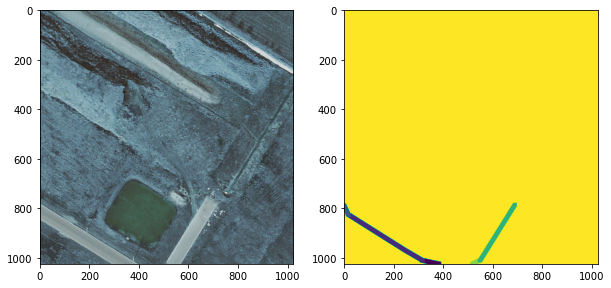

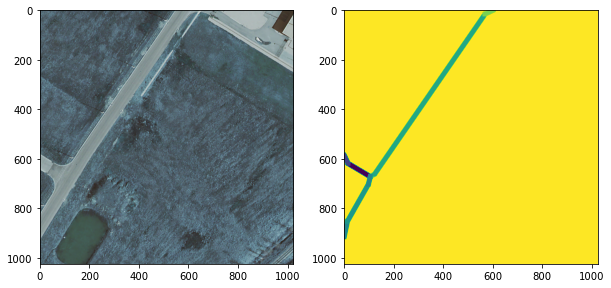

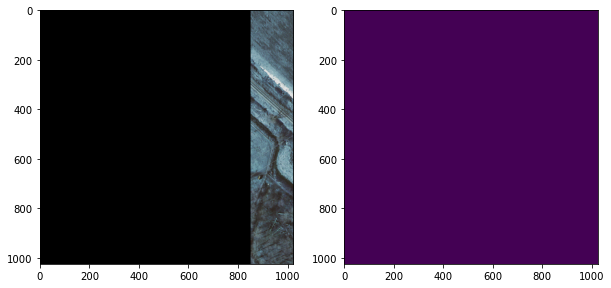

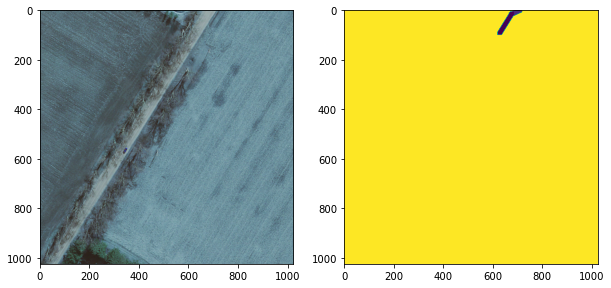

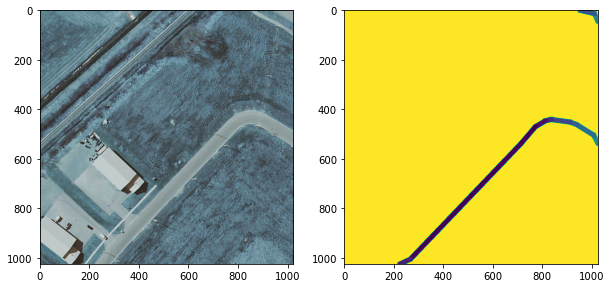

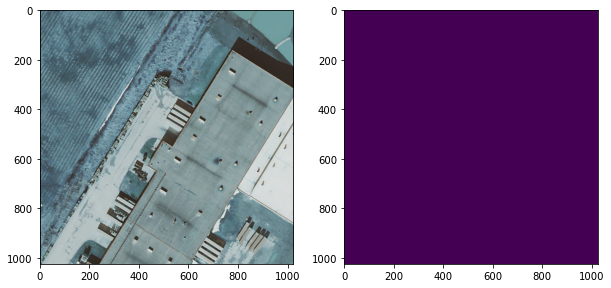

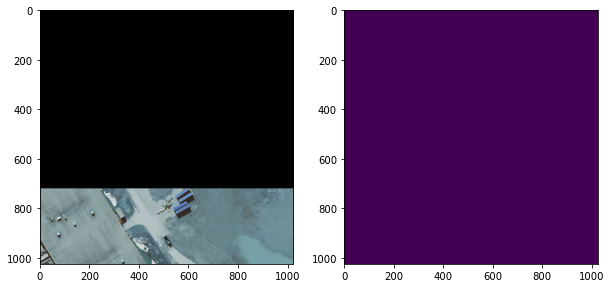

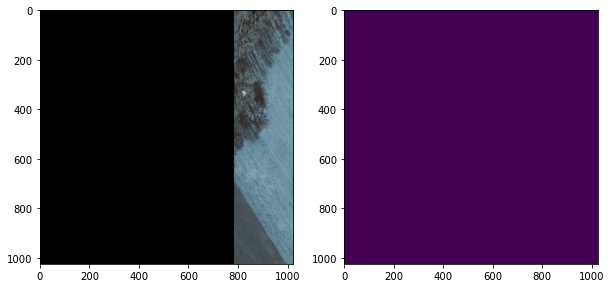

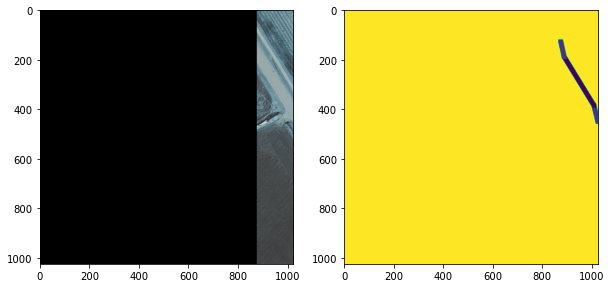

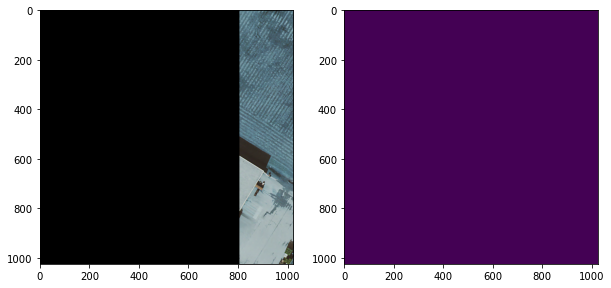

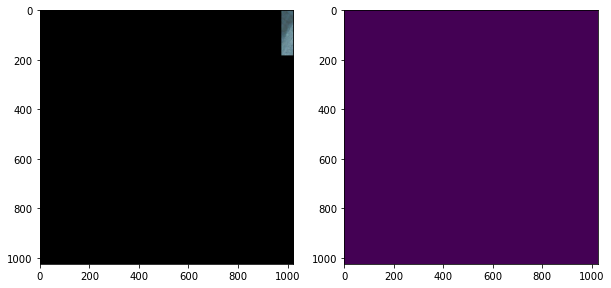

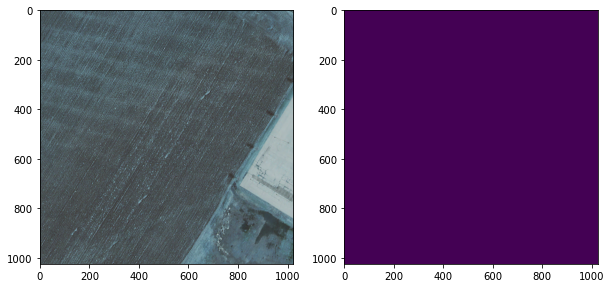

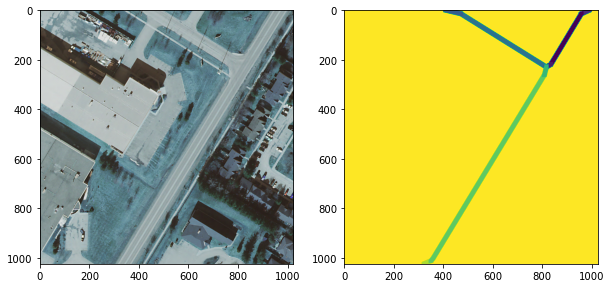

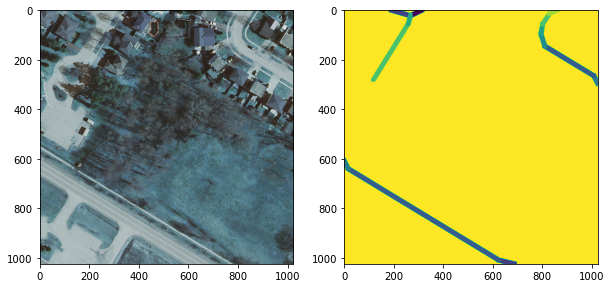

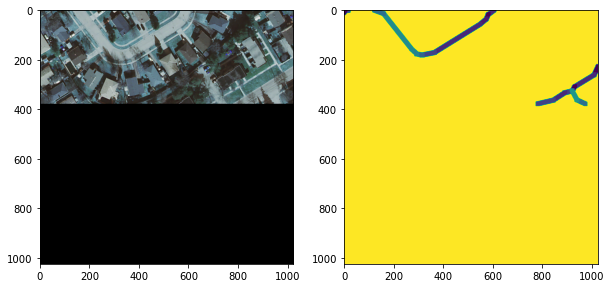

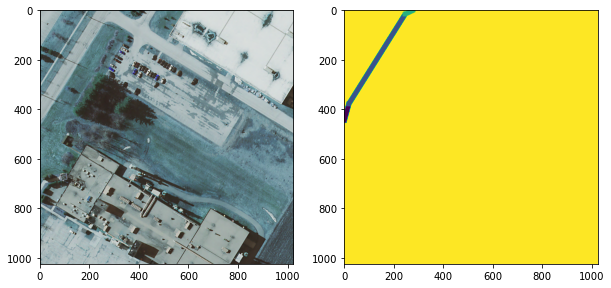

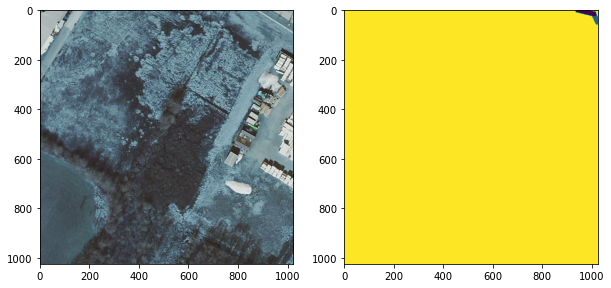

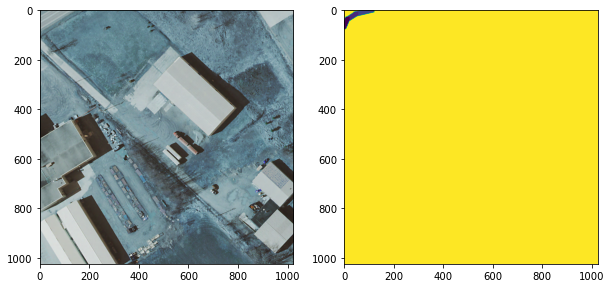

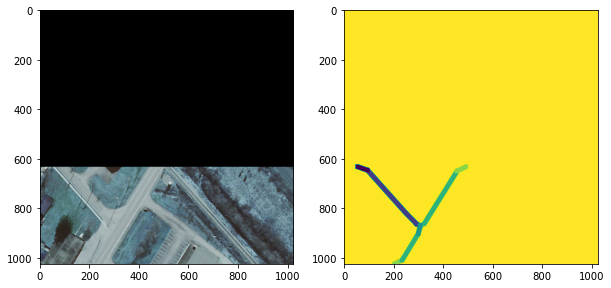

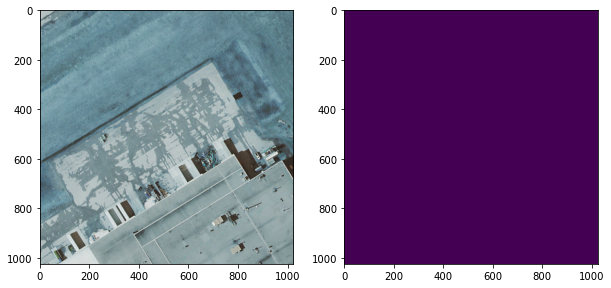

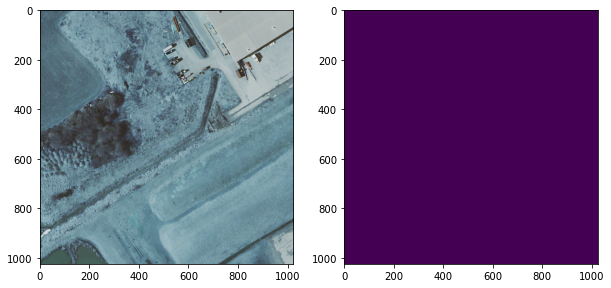

In [ ]:
for i in range(30):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
    ax1.imshow(inputsBGR[i].numpy().transpose(1,2,0))

    ax2.imshow((vecmap_angles[2][i,:,:]))
    plt.show()

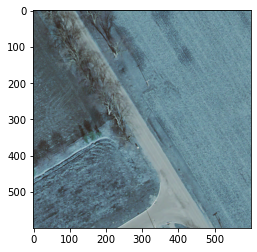

In [38]:
plt.imshow(inputsBGR.numpy().transpose(0,2,3,1)[8])
# print(inputsBGR.shape)

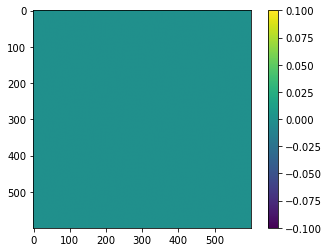

In [39]:
plt.imshow(labels[2][8,:,:])
plt.colorbar()

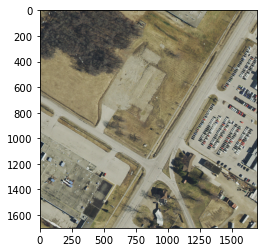

In [21]:
b1 = plt.imread('./data/stratford/crops_1700_1500/train_crops/images/png_1km17499047990SWOOP2015_1_2.png')
plt.imshow(b1)

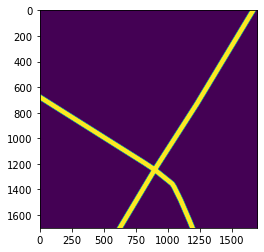

In [22]:
a1 = plt.imread('./data/stratford/crops_1700_1500/train_crops/gt/png_1km17499047990SWOOP2015_1_2.png')
plt.imshow(a1[:,:,0])

In [28]:
a1.max()

0.003921569

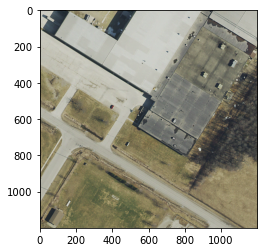

In [24]:
b2 = plt.imread('./data/stratford/crops_1200_1000/train_crops/images/png_1km17499047990SWOOP2015_1_2.png')
plt.imshow(b2)

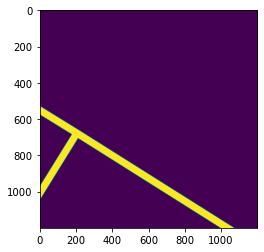

In [40]:
a2 = cv2.imread('./data/stratford/crops_1200_1000/train_crops/gt/png_1km17499047990SWOOP2015_1_2.png')
plt.imshow(a2[:,:,0])

In [41]:
a2.max()

255

In [8]:
train_dataset2 = SpacenetDataset(config["train_dataset"],
                                seed=config["seed"],
                                is_train=True,)

train_loader2 = data.DataLoader(train_dataset2, batch_size=30, shuffle = False)

Threshold is set to 0.76 for train


In [9]:
for i2, sample2 in enumerate(train_loader2):
    inputsBGR2, labels2, vecmap_angles2 = sample2
    
    break

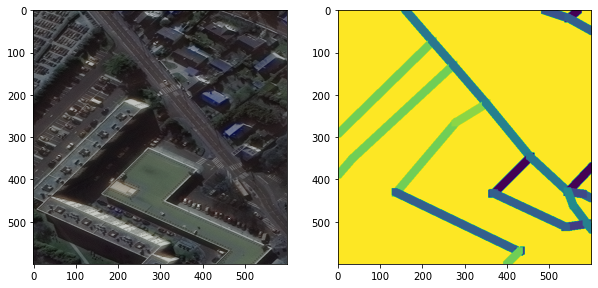

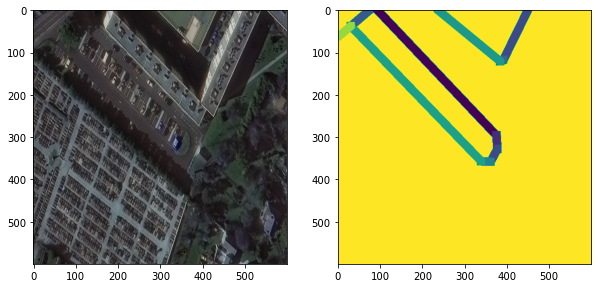

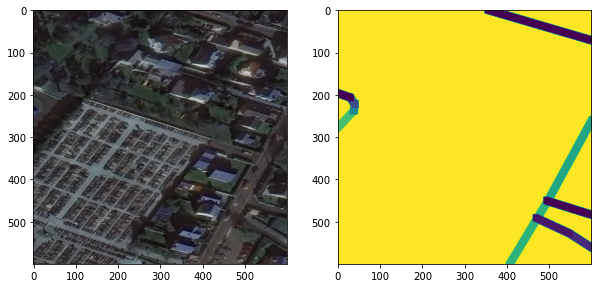

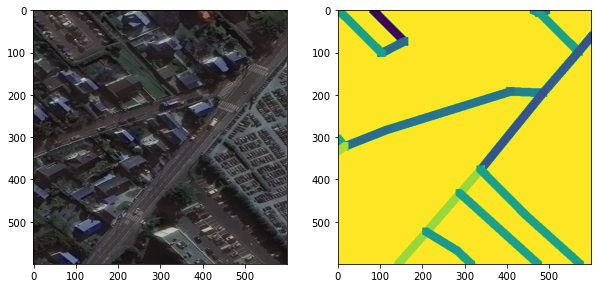

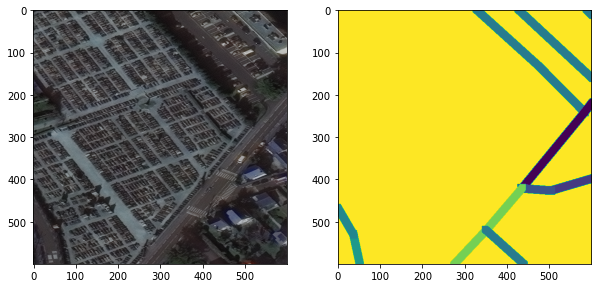

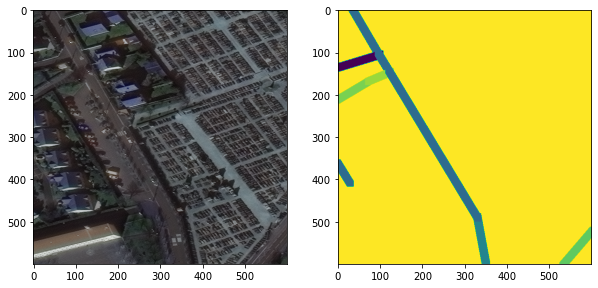

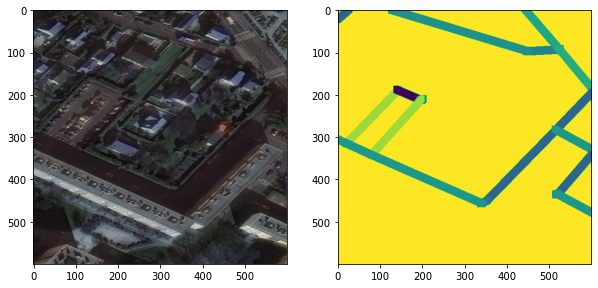

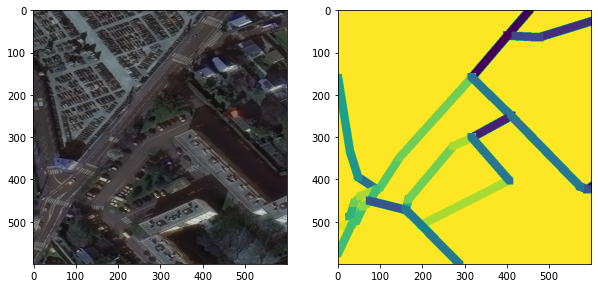

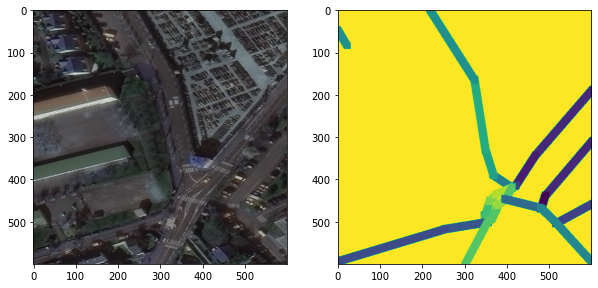

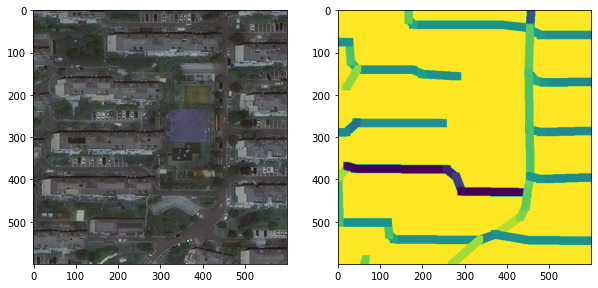

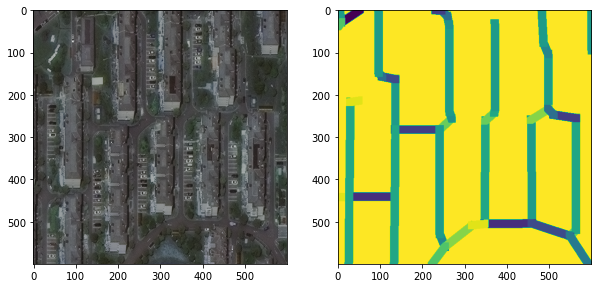

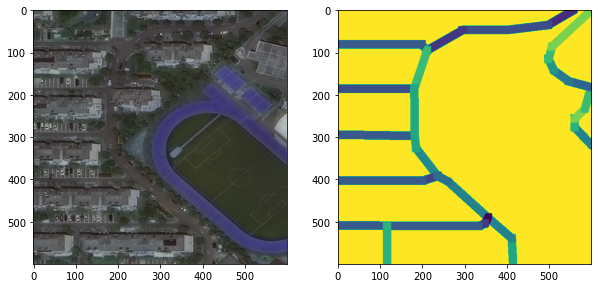

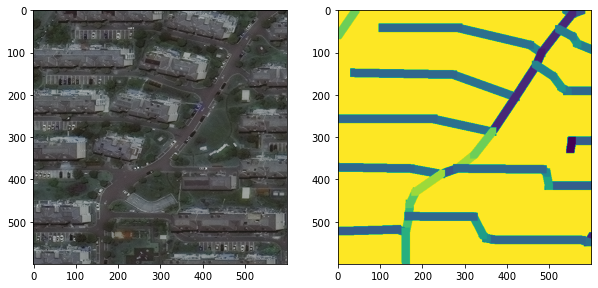

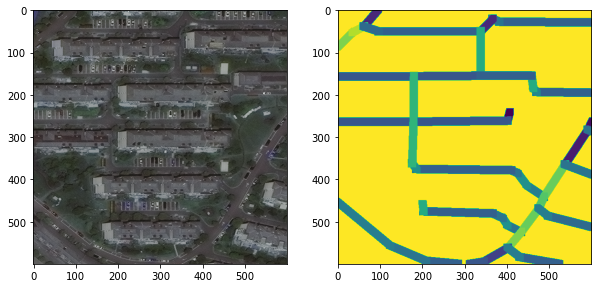

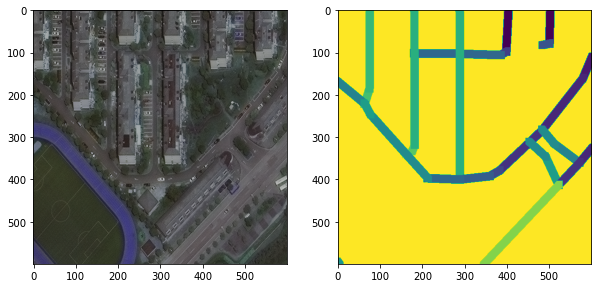

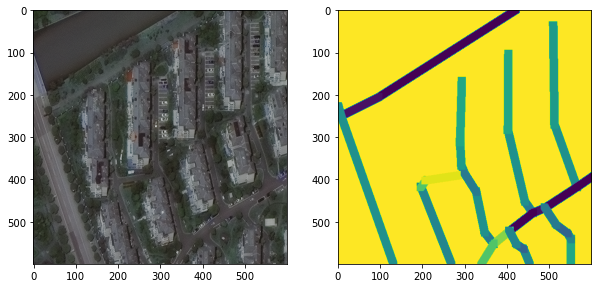

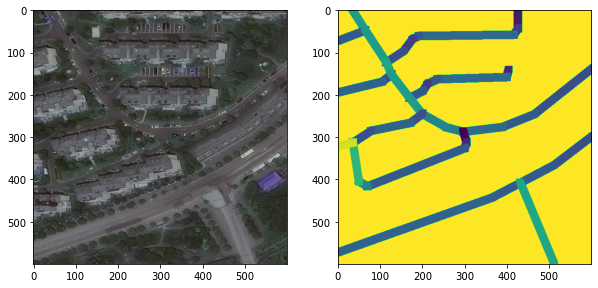

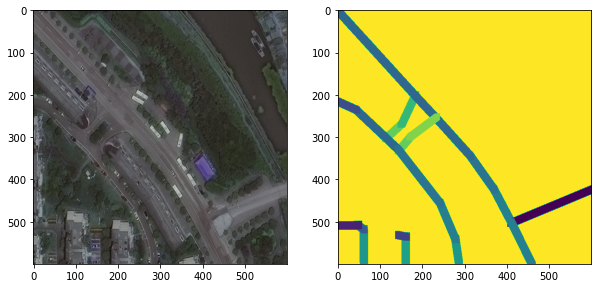

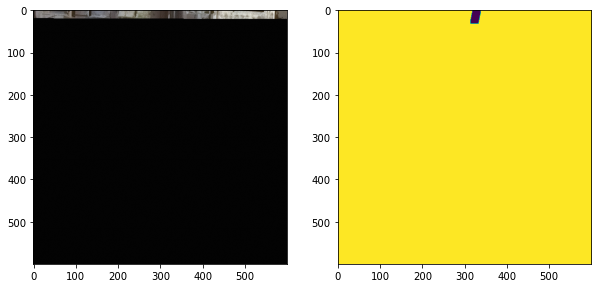

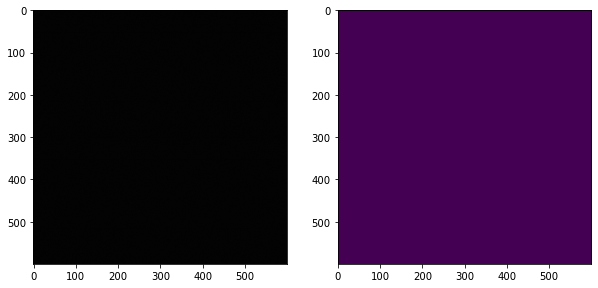

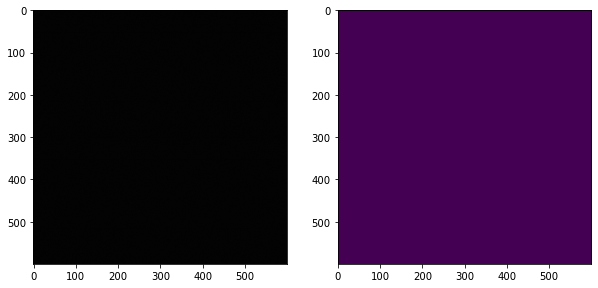

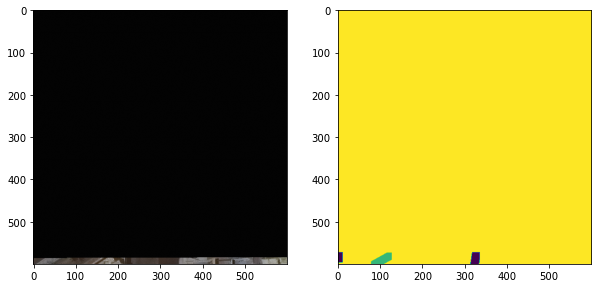

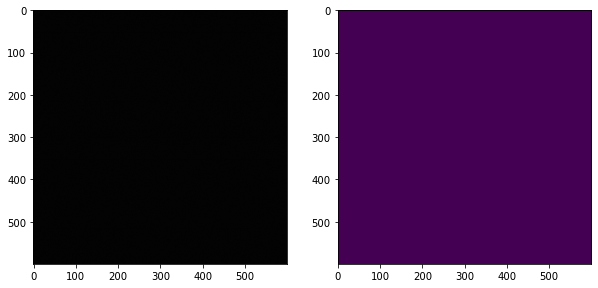

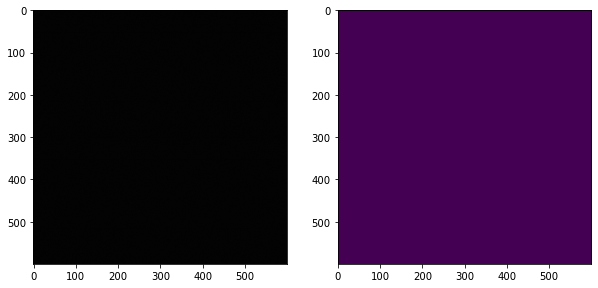

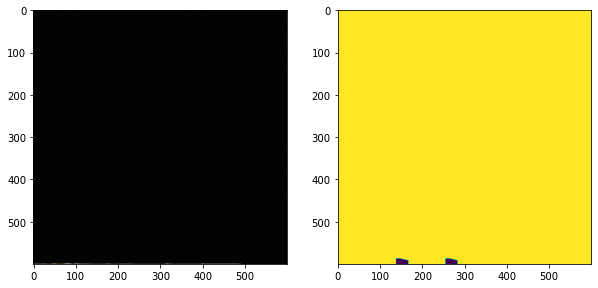

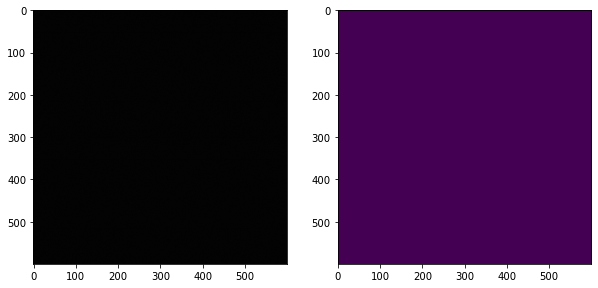

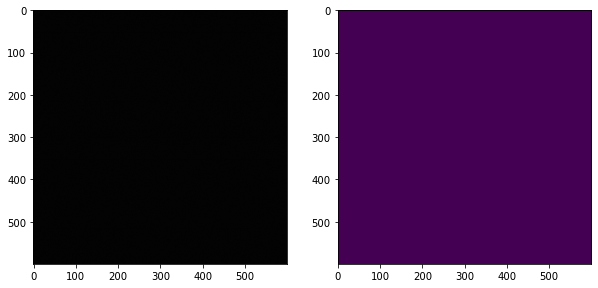

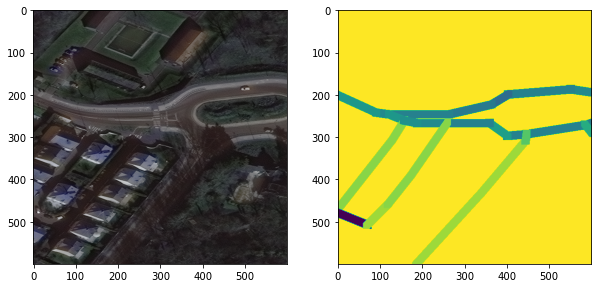

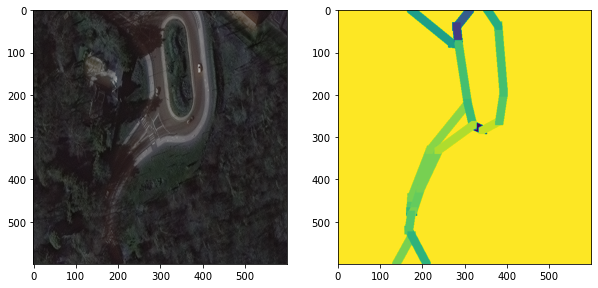

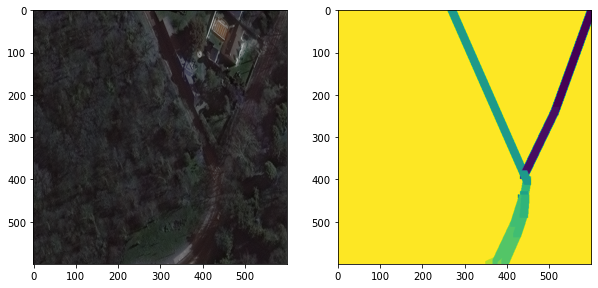

In [10]:
for i in range(30):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
    ax1.imshow(inputsBGR2[i].numpy().transpose(1,2,0))

    ax2.imshow((vecmap_angles2[2][i,:,:]))
    plt.show()

In [57]:
plt.imshow(inputsBGR.numpy().transpose(0,2,3,1)[4])
print(inputsBGR)
print(inputsBGR.shape)

torch.Size([4, 3, 600, 600])

In [58]:
len(labels)

3

In [59]:
len(vecmap_angles)

3

In [60]:
inputsBGR[0,0,0,0]

tensor(0., dtype=torch.float64)

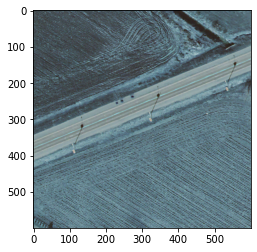

In [62]:
plt.imshow(inputsBGR.numpy().transpose(0,2,3,1)[1].astype(np.uint8))

In [63]:
inputsBGR.numpy().transpose(0,2,3,1)[1]

array([[[  0.        ,   0.        ,   0.        ],
        [ 70.72156863,  77.69411765,  78.69019608],
        [ 68.72941176,  76.69803922,  81.67843137],
        ...,
        [ 83.67058824, 100.60392157, 108.57254902],
        [ 80.68235294, 100.60392157, 110.56470588],
        [ 78.69019608, 101.6       , 112.55686275]],

       [[  0.        ,   0.        ,   0.        ],
        [ 62.75294118,  56.77647059,  57.77254902],
        [ 62.75294118,  58.76862745,  60.76078431],
        ...,
        [ 85.6627451 , 111.56078431, 118.53333333],
        [ 82.6745098 , 110.56470588, 119.52941176],
        [ 80.68235294, 109.56862745, 121.52156863]],

       [[  0.        ,   0.        ,   0.        ],
        [ 69.7254902 ,  92.63529412,  95.62352941],
        [ 67.73333333,  80.68235294,  74.70588235],
        ...,
        [ 94.62745098, 120.5254902 , 125.50588235],
        [ 90.64313725, 117.5372549 , 123.51372549],
        [ 86.65882353, 115.54509804, 122.51764706]],

       ...,

      